## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2022.

# Assignment 1, Task 3: Multilayer Perceptron (MLP)
This is the third part of the assignment. You will get to implement MLP using tensorflow

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 58000 samples from original training set of 60,000
# Validation data: 2000 samples from original training set: 58,000~60,000
# Test data: 10000 samples from original test set
# Development data (for gradient check): 100 from the training set

num_training = 58000
num_validation = 2000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(58000, 784) (2000, 784) (10000, 784) (100, 784)
Train data shape:  (58000, 784)
Train labels shape:  (58000,)
Validation data shape:  (2000, 784)
Validation labels shape:  (2000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Tensorflow MLP (15%)
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net, of which style is referred to https://www.tensorflow.org/guide/keras, and https://www.tensorflow.org/guide/eager. 

You need to implement a multi-layer with 4 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [3]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b2 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 58000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 15
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.7404999732971191
epoch 2: valid acc = 0.7795000076293945
epoch 3: valid acc = 0.8059999942779541
epoch 4: valid acc = 0.8149999976158142
epoch 5: valid acc = 0.828499972820282
epoch 6: valid acc = 0.8355000019073486
epoch 7: valid acc = 0.843500018119812
epoch 8: valid acc = 0.8550000190734863
epoch 9: valid acc = 0.8585000038146973
epoch 10: valid acc = 0.8610000014305115
epoch 11: valid acc = 0.862500011920929
epoch 12: valid acc = 0.8659999966621399
epoch 13: valid acc = 0.8715000152587891
epoch 14: valid acc = 0.8744999766349792
epoch 15: valid acc = 0.8734999895095825
test acc = 0.8578000068664551


### Create Deeper Network

<span style="color:red"><strong>TODO</strong></span>: Create your 4-layer MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" to store your network parameters (weights and bias). Consider using a loop to create your MLP network. Hint: Copy the above code and make necessary changes in model definition.

In [4]:
# Create you MLP using TensorFlow functions.
layer1_dim = 256
layer2_dim = 128
layer3_dim = 64

reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], layer1_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((layer1_dim,)).astype('float32'))
        
        self.W2 = tf.Variable(1e-2*np.random.rand(layer1_dim, layer2_dim).astype('float32'))
        self.b2 = tf.Variable(np.zeros((layer2_dim,)).astype('float32'))
        
        self.W3 = tf.Variable(1e-2*np.random.rand(layer2_dim, layer3_dim).astype('float32'))
        self.b3 = tf.Variable(np.zeros((layer3_dim,)).astype('float32'))
        
        self.W4 = tf.Variable(1e-2*np.random.rand(layer3_dim, 20).astype('float32'))
        self.b4 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        h2 = tf.nn.relu(tf.matmul(h1, self.W2) + self.b2)
        h3 = tf.nn.relu(tf.matmul(h2, self.W3) + self.b3)
        out = tf.matmul(h3, self.W4) + self.b4
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2) + tf.nn.l2_loss(model.W3) + tf.nn.l2_loss(model.W4)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2, model.W3, model.b3, model.W4, model.b4])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 58000
batch_size = 100
num_batch = num_train//batch_size
num_epochs = 25
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2, model.W3, model.b3, model.W4, model.b4]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.18700000643730164
epoch 2: valid acc = 0.18799999356269836
epoch 3: valid acc = 0.18649999797344208
epoch 4: valid acc = 0.1875
epoch 5: valid acc = 0.18549999594688416
epoch 6: valid acc = 0.18950000405311584
epoch 7: valid acc = 0.20250000059604645
epoch 8: valid acc = 0.22450000047683716
epoch 9: valid acc = 0.22550000250339508
epoch 10: valid acc = 0.3840000033378601
epoch 11: valid acc = 0.4009999930858612
epoch 12: valid acc = 0.3580000102519989
epoch 13: valid acc = 0.4429999887943268
epoch 14: valid acc = 0.46149998903274536
epoch 15: valid acc = 0.4970000088214874
epoch 16: valid acc = 0.5860000252723694
epoch 17: valid acc = 0.6554999947547913
epoch 18: valid acc = 0.6899999976158142
epoch 19: valid acc = 0.7179999947547913
epoch 20: valid acc = 0.7425000071525574
epoch 21: valid acc = 0.7584999799728394
epoch 22: valid acc = 0.7699999809265137
epoch 23: valid acc = 0.7710000276565552
epoch 24: valid acc = 0.7785000205039978
epoch 25: valid acc = 0.7825

### Introduction to TensorFlow.keras

As you can see, when the network structure becomes larger, it is hard to handle variables from every layer. Here we introduce the `tf.keras` tool to build the network in a much simpler way. You may want to use it in your project.

<span style="color:red"><strong>TODO</strong></span>: Follow this official example: https://www.tensorflow.org/datasets/keras_example#step_2_create_and_train_the_model to build an MLP and train it. 

*You should keep the same optimizer (SGD) and loss function (cross entropy) as in the previous task.*

**Note:** Since we want to use our own dataset, we will not use the `tfds.load` method to load the data this time. 

You need to check the usage of [`model.fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) and feed the model with our own data.

**Tips:**
* Softmax is also registered as a layer operation in tf.keras.
* You can use `model.summary()` to visualize the model after you build it.
* Use `verbose=2` in `model.fit()` to get similar training logs

In [5]:
#############################################################
# TODO: build the model with tf.keras.models.Sequential

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

# END of your code
#############################################################
#############################################################
# TODO: compile the model, set optimizer and loss

model.compile(
    optimizer=tf.keras.optimizers.SGD(0.001),
    #loss = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20)),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# END of your code
#############################################################
#############################################################
# TODO: train the model with our own dataset

model.fit(
    X_train,
    y_train,
    verbose=2,
    epochs=25,
    validation_data=(X_val,y_val)
)

# END of your code
#############################################################

Epoch 1/25
1813/1813 - 3s - loss: 1.2219 - sparse_categorical_accuracy: 0.7439 - val_loss: 0.5579 - val_sparse_categorical_accuracy: 0.7975
Epoch 2/25
1813/1813 - 3s - loss: 0.5202 - sparse_categorical_accuracy: 0.8156 - val_loss: 0.4998 - val_sparse_categorical_accuracy: 0.8125
Epoch 3/25
1813/1813 - 3s - loss: 0.4466 - sparse_categorical_accuracy: 0.8372 - val_loss: 0.4561 - val_sparse_categorical_accuracy: 0.8355
Epoch 4/25
1813/1813 - 3s - loss: 0.4049 - sparse_categorical_accuracy: 0.8510 - val_loss: 0.4412 - val_sparse_categorical_accuracy: 0.8405
Epoch 5/25
1813/1813 - 3s - loss: 0.3766 - sparse_categorical_accuracy: 0.8585 - val_loss: 0.4257 - val_sparse_categorical_accuracy: 0.8430
Epoch 6/25
1813/1813 - 3s - loss: 0.3534 - sparse_categorical_accuracy: 0.8679 - val_loss: 0.4060 - val_sparse_categorical_accuracy: 0.8505
Epoch 7/25
1813/1813 - 3s - loss: 0.3351 - sparse_categorical_accuracy: 0.8746 - val_loss: 0.4248 - val_sparse_categorical_accuracy: 0.8465
Epoch 8/25
1813/1813

## Part 2: t-SNE (5%)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR100. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [6]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP
from utils.features.tsne import tsne

In [7]:
# Load the raw Fashion-MNIST data.
train_data, test_data = fashion_mnist.load_data()

X_train_raw, y_train = train_data
X_test_raw, y_test = test_data

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 58000 samples from original training set of 60,000
# Validation data: 2000 samples from original training set: 58,000~60,000
# Test data: 10000 samples from original test set
# Development data (for gradient check): 100 from the training set
num_training = 58000
num_validation = 2000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(58000, 784) (2000, 784) (10000, 784) (100, 784)
Train data shape:  (58000, 784)
Train labels shape:  (58000,)
Validation data shape:  (2000, 784)
Validation labels shape:  (2000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


#### tSNE of original data

In [8]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test_raw[random_select,:,:].reshape(500,X_train.shape[1]).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=25.0)
print("it takes {} seconds".format(time.time()-tic))

2.7979442708439266
The 100 th loop cost: 12.098062938737696, computation time: 1.6509387493133545
The 200 th loop cost: 0.6057726412783171, computation time: 3.3157835006713867
The 300 th loop cost: 0.5647899225102556, computation time: 4.974783897399902
The 400 th loop cost: 0.5576933661851946, computation time: 6.679643630981445
The 500 th loop cost: 0.5560836685550278, computation time: 8.369215965270996
The 600 th loop cost: 0.555484738627642, computation time: 10.035169839859009
The 700 th loop cost: 0.5551946571951843, computation time: 11.718954801559448
The 800 th loop cost: 0.5550320099397845, computation time: 13.419721841812134
The 900 th loop cost: 0.5549333517055253, computation time: 15.098404169082642
The 1000 th loop cost: 0.5548691099686345, computation time: 16.75897717475891
it takes 17.429158687591553 seconds


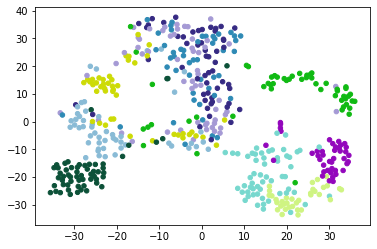

In [9]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

Do visualization of the tSNE of data after going through MLP. In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, tSNE of data after two-layer networks would be shown as multiple clusters in a 2D panel.

In [10]:
# Define MLP model
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100], num_classes=20, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 290
epoch 1: valid acc = 0.807, new learning rate = 0.00095
epoch 2: valid acc = 0.843, new learning rate = 0.0009025
epoch 3: valid acc = 0.8545, new learning rate = 0.000857375
epoch 4: valid acc = 0.8725, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.8725, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.866, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.8715, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.874, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.877, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.878, new learning rate = 0.0005987369392383785
test acc: 0.8694


0.8694

<span style="color:red"><strong>TODO</strong></span>: Visualize data that is passed through MLP model defined above using tSNE. 

In [11]:
# run tSNE
X = X_test[random_select]
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
# Hint: Pass data through affine and dense layers (model.layers) and then   #
# apply softmax to obtain output of the MLP model.                          #
#############################################################################

layer1_out = model.layers[0].feedforward(X)
layer2_out = model.layers[1].feedforward(layer1_out)

X = np.exp(layer2_out) / np.sum(np.exp(layer2_out), axis=1, keepdims=True)

tic = time.time()
Y = tsne(X, low_dim=2, perplexity=25.0)
print("it takes {} seconds".format(time.time()-tic))


#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

0.10023665997647219
The 100 th loop cost: 8.709797246876445, computation time: 1.7352585792541504
The 200 th loop cost: 0.22766839954002213, computation time: 3.447017192840576
The 300 th loop cost: 0.18862510735318133, computation time: 5.118504524230957
The 400 th loop cost: 0.1766274060268464, computation time: 6.800467252731323
The 500 th loop cost: 0.17215762594278022, computation time: 8.479564905166626
The 600 th loop cost: 0.16974322963615002, computation time: 10.138876676559448
The 700 th loop cost: 0.16819745101840913, computation time: 11.808665752410889
The 800 th loop cost: 0.16709446841189218, computation time: 13.460225343704224
The 900 th loop cost: 0.16627551458262393, computation time: 15.111788034439087
The 1000 th loop cost: 0.16563271804048396, computation time: 16.7671000957489
it takes 17.56077265739441 seconds
it takes 17.561059713363647 seconds


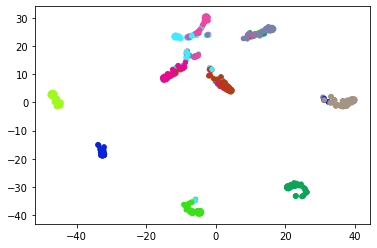

In [12]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
# Hint: See tSNE visualization of original data                             #
#############################################################################

labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of tSNE, do visualization of the new tSNE of data.

In [13]:
# Tune the parameter, show the results.
# run tSNE
X = X_test[random_select]


#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################

layer1_out = model.layers[0].feedforward(X)
layer2_out = model.layers[1].feedforward(layer1_out)

X = np.exp(layer2_out) / np.sum(np.exp(layer2_out), axis=1, keepdims=True)

tic = time.time()
Y = tsne(X, low_dim=2, perplexity=5.0)
print("it takes {} seconds".format(time.time()-tic))

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

0.03894469995336435
The 100 th loop cost: 12.33478507508985, computation time: 1.7097139358520508
The 200 th loop cost: 0.6706942895697737, computation time: 3.4093263149261475
The 300 th loop cost: 0.452635107346044, computation time: 5.126781463623047
The 400 th loop cost: 0.37189553133058123, computation time: 6.821353197097778
The 500 th loop cost: 0.34206769508106655, computation time: 8.524313926696777
The 600 th loop cost: 0.3258667430114315, computation time: 10.221276760101318
The 700 th loop cost: 0.3154193165344918, computation time: 11.90363359451294
The 800 th loop cost: 0.30792145714329633, computation time: 13.58789849281311
The 900 th loop cost: 0.3021970337128842, computation time: 15.309667348861694
The 1000 th loop cost: 0.2975918126420819, computation time: 17.04830265045166
it takes 18.003678798675537 seconds
it takes 18.003976106643677 seconds


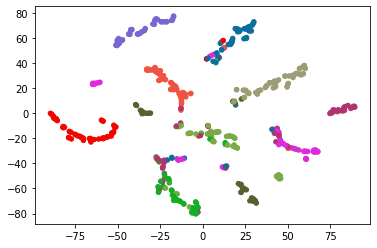

In [14]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################

labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################